In [14]:
import math

import gpytorch
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)

# True function is sin(2*pi*x) with Gaussian noise
train_y = (
    torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2
)

In [33]:
train_x_distributional = torch.stack((train_x_mean, (train_x_stdv**2).log()), dim=1)
train_x_distributional

tensor([[ 0.0000, -7.0131],
        [ 0.0526, -7.0846],
        [ 0.1053, -7.1586],
        [ 0.1579, -7.2356],
        [ 0.2105, -7.3156],
        [ 0.2632, -7.3989],
        [ 0.3158, -7.4859],
        [ 0.3684, -7.5768],
        [ 0.4211, -7.6721],
        [ 0.4737, -7.7721],
        [ 0.5263, -7.8774],
        [ 0.5789, -7.9885],
        [ 0.6316, -8.1062],
        [ 0.6842, -8.2312],
        [ 0.7368, -8.3646],
        [ 0.7895, -8.5075],
        [ 0.8421, -8.6615],
        [ 0.8947, -8.8282],
        [ 0.9474, -9.0102],
        [ 1.0000, -9.2103]])

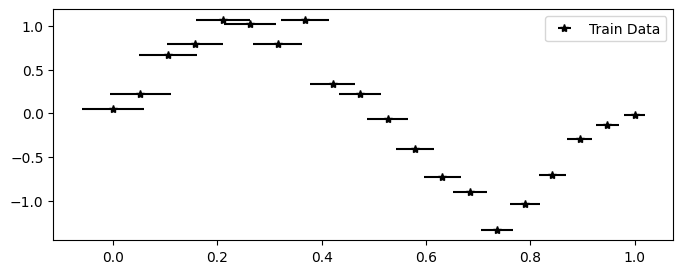

In [4]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(
    train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data"
)
ax.legend()

In [15]:
def g(x):
    return -(torch.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [16]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test

In [17]:
x_train, y_train, x_test, y_test = generate_data()

In [18]:
from gpytorch.kernels import (
    PeriodicKernel,
    RBFKernel,
    ScaleKernel,
)
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP


class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel() + PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_distributional, train_y, likelihood)

In [32]:
# this is for running the notebook in our testing framework
import os

smoke_test = "CI" in os.environ
training_iter = 2 if smoke_test else 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.25
)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.MarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_distributional)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # print(
    #     "Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f"
    #     % (
    #         i + 1,
    #         training_iter,
    #         loss.item(),
    #         model.covar_module.base_kernel.lengthscale.item(),
    #         model.likelihood.noise.item(),
    #     )
    # )
    print(
        "Iter %d/%d - Loss: %.3f    noise: %.3f"
        % (
            i + 1,
            training_iter,
            loss.item(),
            model.likelihood.noise.item(),
        )
    )
    optimizer.step()

NotImplementedError: 

In [30]:
model.covar_module.base_kernel

AdditiveKernel(
  (kernels): ModuleList(
    (0): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (1): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
  )
)